## AI Glass Detection ##

## Amaç ## 
Yapay Zeka tarafından oluşturulan resimlerden gözlük takıp takmadığını belirlemek için yapay zeka kullanmalısınız. Görseller farklı açılardan, yakınlaştırma seviyelerinden ve aydınlatma koşullarından oluşur ve çeşitli insan gruplarını temsil eder. Görseller 512x512 boyutundadır ve Stable Diffusion ile üretilmiştir; gerçek kişiler değillerdir.

Başlangıç: 30 Ekim 2023
Bitiş: 28 Kasım 2023

Değerlendirme
Logloss ile değerlendirileceksiniz.

Gönderim Dosyası
Test setindeki her ID için gözlük değişkeni için bir olasılık tahmin etmelisiniz. Dosya şu formatta olmalıdır:

python
Kodu kopyala
id,glasses
2,0
5,0
6,0
...
Alıntı
Jeff Heaton. (2023). Applications of Deep Learning (WUSTL, Fall 2023). Kaggle. https://kaggle.com/competitions/applications-of-deep-learning-wustl-fall-2023

## Kütüphaneleri Yükle ##

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Veri Setini Yükle 

In [2]:
train=pd.read_csv("/kaggle/input/applications-of-deep-learning-wustl-fall-2023/train.csv")
test=pd.read_csv("/kaggle/input/applications-of-deep-learning-wustl-fall-2023/test.csv")

## EDA ##

In [3]:
train.head()

,id,file,glasses
0,1,1.jpg,0
1,2,2.jpg,0
2,3,3.jpg,1
3,4,4.jpg,0
4,5,5.jpg,1


In [4]:
train.shape,test.shape

((24999, 3), (6865, 2))

In [5]:
img_path = r"/kaggle/input/applications-of-deep-learning-wustl-fall-2023"

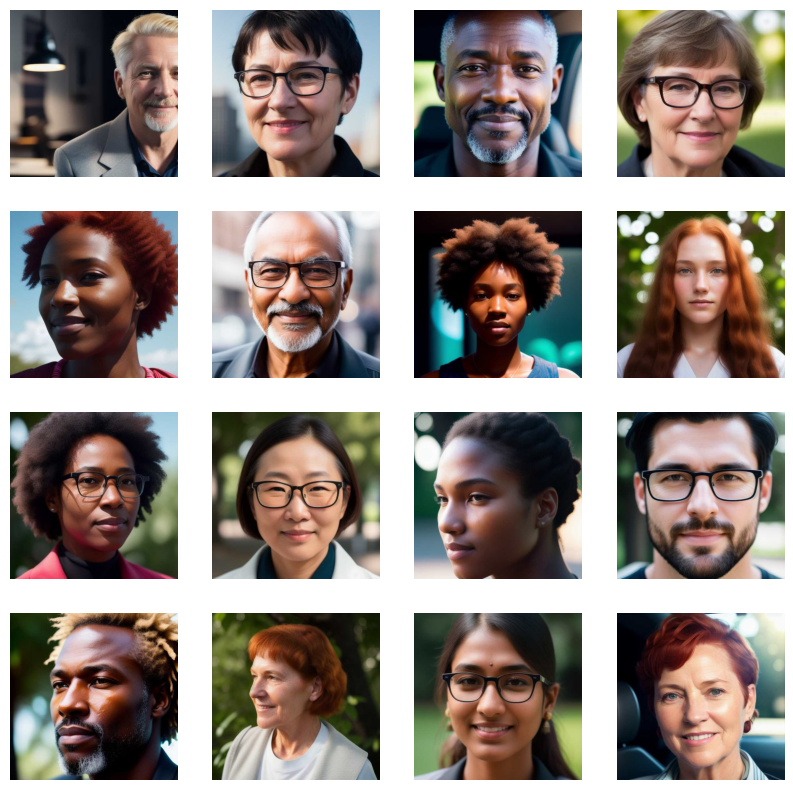

In [6]:
files = os.listdir(img_path)
random_files = random.sample(files, 16)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    img = cv2.imread(os.path.join(img_path, random_files[i]))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()

## Img Preprocessing ##

In [7]:
def pre_img(df, img_path, size=128):
    X = []
    for img in df:
        img_file = os.path.join(img_path, str(img))
        img = cv2.imread(img_file)
        img = cv2.resize(img, (size, size))
        img = img / 255.0
        X.append(img)
    X = np.array(X)
    return X

## Özellikleri ve Hedefi Belirle ##

In [8]:
X_train = pre_img(train["file"], img_path)
y_train = train["glasses"]

## Model Oluştur ve Değerlendir ##

### Kütüphaneleri İçe Aktar ##

In [9]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.20, random_state=42)
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Dropout,BatchNormalization

2024-09-04 08:22:02.408820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 08:22:02.408942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 08:22:02.542702: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

size=128
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(size, size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

# Erken Durdurma
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Modeli Eğit ##

In [11]:
# Eğitim
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping],verbose=1)

Epoch 1/100
  2/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.4062 - loss: 3.3512   

I0000 00:00:1725438158.830321     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1725438158.857421     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5609 - loss: 2.5705

W0000 00:00:1725438191.968420     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - accuracy: 0.5610 - loss: 2.5685 - val_accuracy: 0.8022 - val_loss: 0.4596
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.8461 - loss: 0.3751 - val_accuracy: 0.9410 - val_loss: 0.1696
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9328 - loss: 0.1648 - val_accuracy: 0.9540 - val_loss: 0.1294
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.9590 - loss: 0.1172 - val_accuracy: 0.9722 - val_loss: 0.0772
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9660 - loss: 0.0950 - val_accuracy: 0.9764 - val_loss: 0.0603
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9743 - loss: 0.0682 - val_accuracy: 0.9198 - val_loss: 0.2507
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9791 - loss: 0.0639 - val_accuracy: 0.9378 - val_loss: 0.2053
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.9810 - loss: 0.0567 - val_

## Submission Oluşturma ##

In [12]:
X_test = pre_img(test["file"], img_path)
submission = pd.read_csv("/kaggle/input/applications-of-deep-learning-wustl-fall-2023/sample_submission.csv")
submission["glasses"] = model.predict(X_test).round().astype(int)
submission.to_csv("submission.csv", index=False)
submission

 20/215 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 

W0000 00:00:1725438640.588437     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


,id,glasses
0,25000,1
1,25001,0
2,25002,0
3,25003,1
4,25004,1
...,...,...
6860,31860,0
6861,31861,1
6862,31862,0
6863,31863,0


## Modeli Kaydet ##

In [13]:
model.save("model_glass.keras")